Deconvoluting spatial transcriptomics datasets with Stereoscope
===============================================================

This tutorial shows how to use **Stereoscope** for deconvolution of spatial transcriptomics data.

- [paper]( https://www.nature.com/articles/s42003-020-01247-y)
- code [1](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.RNAStereoscope.html#scvi.external.RNAStereoscope) and [2](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.SpatialStereoscope.html#scvi.external.SpatialStereoscope)
- [tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/stereoscope_heart_LV_tutorial.html)

For an in-depth overview of the method, check out the scvi [user guide](https://docs.scvi-tools.org/en/stable/user_guide/models/stereoscope.html?highlight=stereoscope).

Similar (more recent) tools that solve the same problem with more advanced parametrizations are:
- [destvi](https://docs.scvi-tools.org/en/stable/user_guide/models/destvi.html?highlight=destvi)
- [cell2location](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html?highlight=cell2location#Mapping-human-lymph-node-cell-types-to-10X-Visium-with-Cell2location)

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import anndata as ad
import squidpy as sq


sc.set_figure_params(figsize=(4, 4), frameon=False)

In [2]:
# set path
path = pathlib.Path("/Users/giovanni.palla/Datasets/advomics/advomics_data_spatial")

Data preparation
----------------

Read in data and standard preprocessing with Scanpy and Umap visualization.

In [3]:
sc_adata = sc.read(path / "dh_sc.h5ad")
sc_adata.var_names_make_unique()
sc.pp.subsample(sc_adata, fraction=0.2, random_state=42)
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.astype(np.float64).copy()
sc_adata = sc_adata[
    sc_adata.obs.Main_cluster_name != "Erythroblasts"
].copy()  # remove Erythroblasts cause they are too few
sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3']
  warnings.warn(


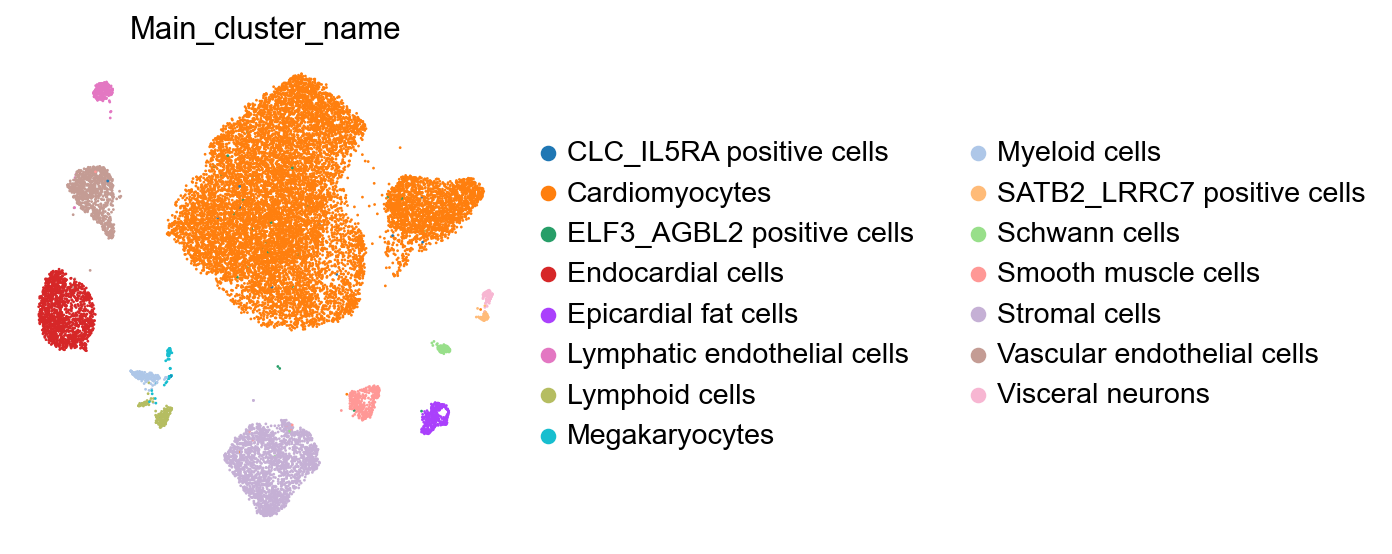

In [4]:
sc.pl.umap(sc_adata, color="Main_cluster_name")

Do the same for the spatial dataset.

In [5]:
st_adata = sc.read(path / "V10F24-105_A1.h5ad")
st_adata.var_names_make_unique()
sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

In [6]:
st_adata.layers["counts"].max()

7503.0

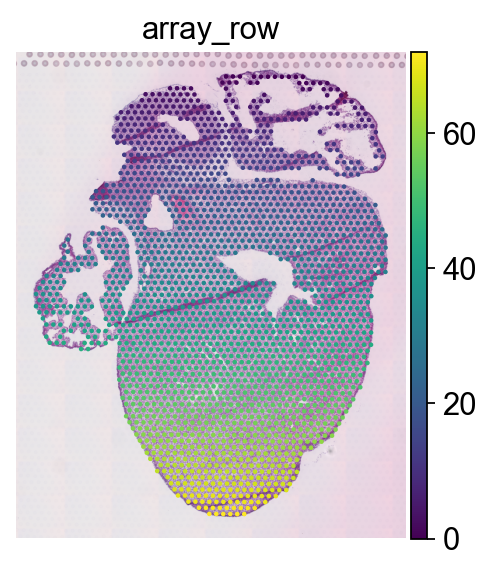

In [7]:
sc.pl.spatial(st_adata, color="array_row")

Find unique genes between single cell and spatial.

In [8]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

Prepare RNAStereoscope model and train.

In [9]:
from scvi.external import RNAStereoscope, SpatialStereoscope

RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="Main_cluster_name")

Global seed set to 0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 100/100: 100%|████████████████████████| 100/100 [02:45<00:00,  1.66s/it, loss=1.6e+04, v_num=1]


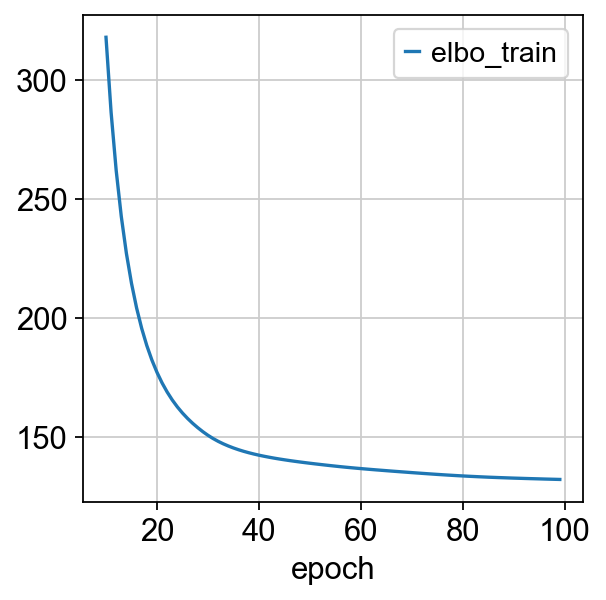

In [10]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs=100, use_gpu=False)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

Do the same for spatial model.

In [11]:
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1000/1000: 100%|███████████████████| 1000/1000 [02:54<00:00,  5.73it/s, loss=8.73e+05, v_num=1]


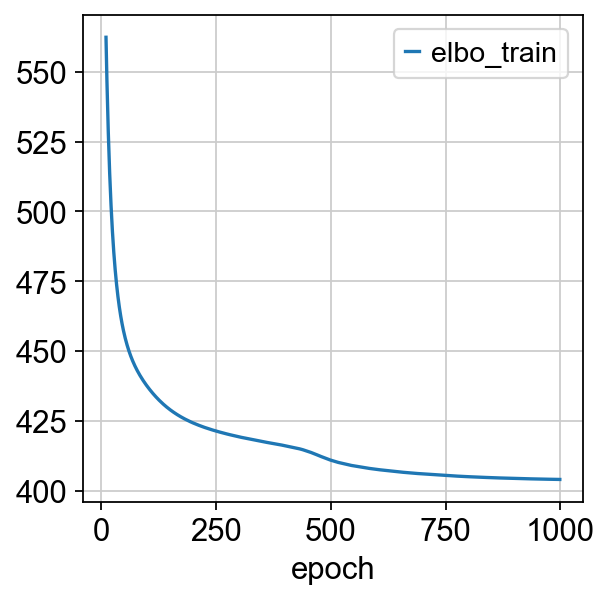

In [12]:
train = True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(
        st_adata, sc_model, layer="counts"
    )
    spatial_model.train(max_epochs=1000)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite=True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", adata=st_adata)
    print("Loaded Spatial model from file!")

Transfer deconvolution to ``adata.obs``.

In [13]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

In [14]:
st_adata.obsm["deconvolution"].columns

Index(['CLC_IL5RA positive cells', 'Cardiomyocytes',
       'ELF3_AGBL2 positive cells', 'Endocardial cells',
       'Epicardial fat cells', 'Lymphatic endothelial cells', 'Lymphoid cells',
       'Megakaryocytes', 'Myeloid cells', 'SATB2_LRRC7 positive cells',
       'Schwann cells', 'Smooth muscle cells', 'Stromal cells',
       'Vascular endothelial cells', 'Visceral neurons'],
      dtype='object')

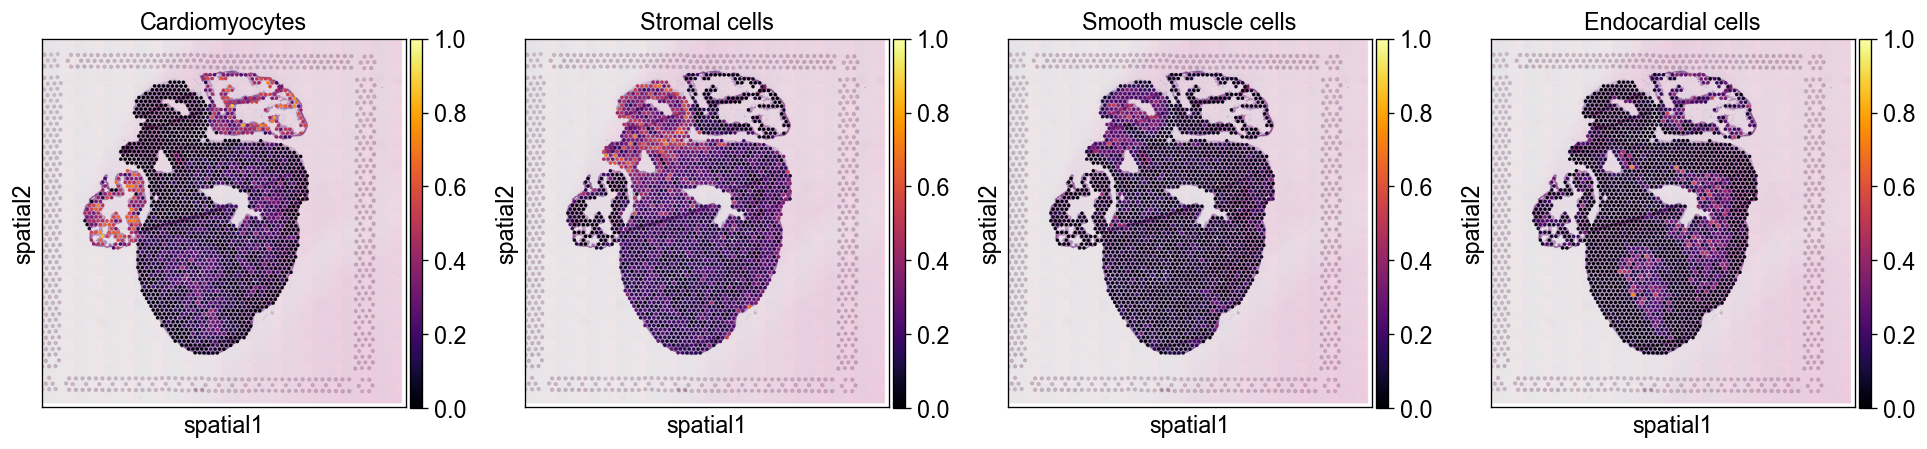

In [17]:
sc.settings.set_figure_params(
    dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
)
sq.pl.spatial_scatter(
    st_adata,
    color=[
        "Cardiomyocytes",
        "Stromal cells",
        "Smooth muscle cells",
        "Endocardial cells",
    ],
    size=1.2,
    cmap="inferno",
    vmin=0,
    vmax=1,
)

### Analysis ideas

#### Spatial co-localization
Which cell-types co-localize together? You can find it by computing correlation and plotting it with an heatmap. Check out [sns.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html) and this:
```python
corr_mat = st_adata.obsm["deconvolution"].corr()
```

For correct color labeling you can get a dictionary of the color palette previously visualized with Umap with this:

```python
cols = dict(
    zip(
        sc_adata.obs["Main_cluster_name"].cat.categories,
        sc_adata.uns["Main_cluster_name_colors"],
    )
)
```

<details>
<summary>Hint</summary>
    
```python
import seaborn as sns
corr_mat = st_adata.obsm["deconvolution"].corr()
cols = dict(
    zip(
        sc_adata.obs["Main_cluster_name"].cat.categories,
        sc_adata.uns["Main_cluster_name_colors"],
    )
)
row_colors = [cols[i] for i in corr_mat.index]
col_colors = [cols[i] for i in corr_mat.columns]
sns.clustermap(corr_mat,row_colors=row_colors, col_colors=col_colors, cmap="inferno", vmin=0, vmax=1)
```
    
</details>


#### Cell-type niches
We can use deconvolution results to find clusters of spots that are similar in cell type composition.
To do so, create a new anndata with the deconvolution results as *features*
```python
adata_prop = ad.AnnData(
    st_adata.obsm["deconvolution"].copy(),
    obsm=st_adata.obsm.copy(),
    obs=st_adata.obs.copy(),
    uns=st_adata.uns.copy(),
)
adata_prop.var_names = st_adata.obsm["deconvolution"].columns
```

and run and then visualize standard scanpy clustering. 

<details>
<summary>Hint</summary>
    
```python
adata_prop = ad.AnnData(
    st_adata.obsm["deconvolution"].copy(),
    obsm=st_adata.obsm.copy(),
    obs=st_adata.obs.copy(),
    uns=st_adata.uns.copy(),
)
adata_prop.var_names = st_adata.obsm["deconvolution"].columns

sc.pp.scale(adata_prop)
sc.pp.neighbors(adata_prop)
sc.tl.leiden(adata_prop)

sq.pl.spatial_scatter(adata_prop, color="leiden")
```
    
</details>


How do they relate to previously found clusters?